# Impacts of Demographic Factors on Math Performance
#### UBC STAT 201 - Group 25

## Introduction

In this report, we investigate the potential impacts of parental education levels on student secondary school mathematics performance. In particular, we explore the differences in students' mean final math grades across groups with highly educated parents, and parents with less formal education. 

Previous research has indicated that several family/household factors have impacts on general educational outcomes (Marks 2006). Students from single parent households in Finland were found to be at higher risk of educational underachievement, and students from larger families in the USA had less favourable educational outcomes (Riala et al., 2003; Blake, 1989). Parental education levels have also been shown to be predictive of child success later in life (Dubow et al., 2009). In this report, we investigate how these factors may impact mathematical performance specifically.

We will use inferential statistical techniques (computing confidence intervals using both CLT and bootstrapping) to determine whether there is significant evidence of a difference in mean math grades between students with more/less formally educated parents. The mean and standard deviation of the response variable G3 (final grade in mathematics) will be important when calculating confidence intervals for the difference in means. We consider the sample size to be large enough (395 observations) to apply the CLT in our calculation of confidence intervals.

The data we are using was collected by Paulo Cortez and Alice Silva from secondary schools in Portugal. Their original paper, with detailed explanations of the sampling process can be found [here](https://www.researchgate.net/publication/228780408_Using_data_mining_to_predict_secondary_school_student_performance). The dataset can be downloaded from the UC Irvine Machine learning repository [here](https://archive.ics.uci.edu/dataset/320/student+performance).

**Variables of Interest**
* `G3`: final grade in mathematics course, numeric [0, 20] (Portugal, France and several other European countries use the 20 point scale)
* `Medu`: mother's education level, factor with 4 levels [0 - none, 1 - primary (4th grade), 2 - 5th to 9th grade, 3 - secondary, 4 - higher education]
* `Fedu`: father's education level, factor with 4 levels (same as Medu)

We will be aggregating each of `Medu` and `Fedu` into 2 level factors (binary) in order to carry out our hypothesis tests. Levels 0-2 will be grouped into a "low education" group, and levels 3-4 create the "high education" group.

**Inferential Research Questions**

Let $\mu_{f-lo}$, $\mu_{f-hi}$ be the mean final mathematics grade of students with fathers in the low and high education groups respectively. Likewise, let $\mu_{m-lo}$, $\mu_{m-hi}$ be the mean final mathematics grade of students with mothers in the low and high education groups respectively. Our 2 hypothesis tests are as follows:

**Test 1: Mothers' Education Level**

* $H_0$: $\mu_{m-lo}$ = $\mu_{m-hi}$
* $H_A$: $\mu_{m-lo}$ < $\mu_{m-hi}$

**Test 2: Fathers' Education Level**

* $H_0$: $\mu_{f-lo}$ = $\mu_{f-hi}$
* $H_A$: $\mu_{f-lo}$ < $\mu_{f-hi}$

Both hypothesis tests will be carried out at the $\alpha$ = 0.05 significance level.<br>


## Methods & Results

In [40]:
library(tidyverse)
library(dplyr)
library(gridExtra)
library(ggplot2)
library(broom)
library(infer)

In [52]:
students <- read.csv("https://raw.githubusercontent.com/aidanmeharg/STAT_201_Project/main/student-mat.csv", sep = ";")

head(students)

school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     ⋯ famrel
1 GP     F   18  U       GT3     A       4    4    at_home  teacher  ⋯ 4     
2 GP     F   17  U       GT3     T       1    1    at_home  other    ⋯ 5     
3 GP     F   15  U       LE3     T       1    1    at_home  other    ⋯ 4     
4 GP     F   15  U       GT3     T       4    2    health   services ⋯ 3     
5 GP     F   16  U       GT3     T       3    3    other    other    ⋯ 4     
6 GP     M   16  U       LE3     T       4    3    services other    ⋯ 5     
  freetime goout Dalc Walc health absences G1 G2 G3
1 3        4     1    1    3       6        5  6  6
2 3        3     1    1    3       4        5  5  6
3 3        2     2    3    3      10        7  8 10
4 2        2     1    1    5       2       15 14 15
5 3        2     1    2    5       4        6 10 10
6 4        2     1    2    5      10       15 15 15

In [53]:
# check for missing values
students %>%
    summarize(num_rows_na = sum(rowSums(is.na(.)) > 0))

num_rows_na
1 0

There are no missing values in the dataset.

In [54]:
# select variables of interest
students_filtered <- students |> select(G3, Medu, Fedu)
head(students_filtered)

G3 Medu Fedu
1  6 4    4   
2  6 1    1   
3 10 1    1   
4 15 4    2   
5 10 3    3   
6 15 4    3

mean     sd      
1 10.41519 4.581443

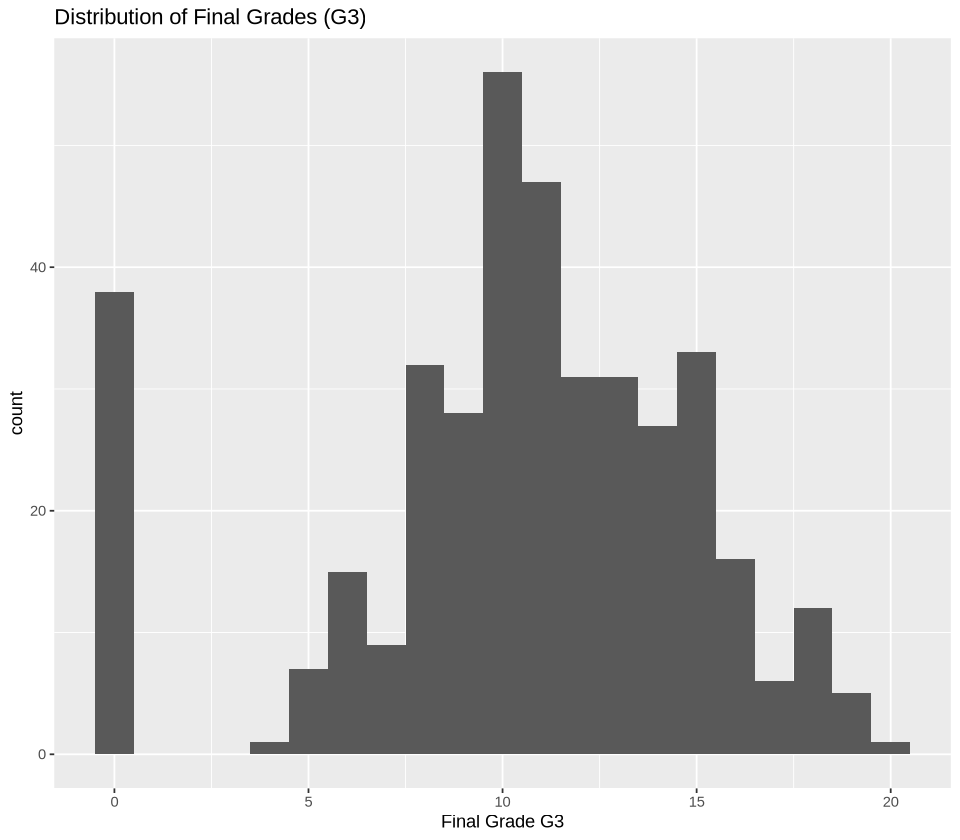

In [55]:
options(repr.plot.width = 8)

ggplot(students, aes(x = G3)) +
    geom_histogram(binwidth = 1) +
    xlab("Final Grade G3") +
    ggtitle("Distribution of Final Grades (G3)")

students |>
    summarize(mean = mean(G3), sd = sd(G3))

#### Figure 1

The mean of the students' final grades is 10.42 out of 20, and the standard deviation for this sample is 4.58. This distribution appears somewhat normal. We notice that there are a large number of students who received a final grade of zero and decide to drop these observations. These data points likely represent a student "dropping-out" of school as opposed to actually performing poorly in assessments. In addition, the mean is quite sensitive to outliers and so these "drop-out" students could have significant effect on mean grades.

In [56]:
# remove students with a final grade of 0 - very unlikely that 
#       anyone attending a class would achieve no marks at all
students_filtered <- students_filtered |> filter(G3 > 0)

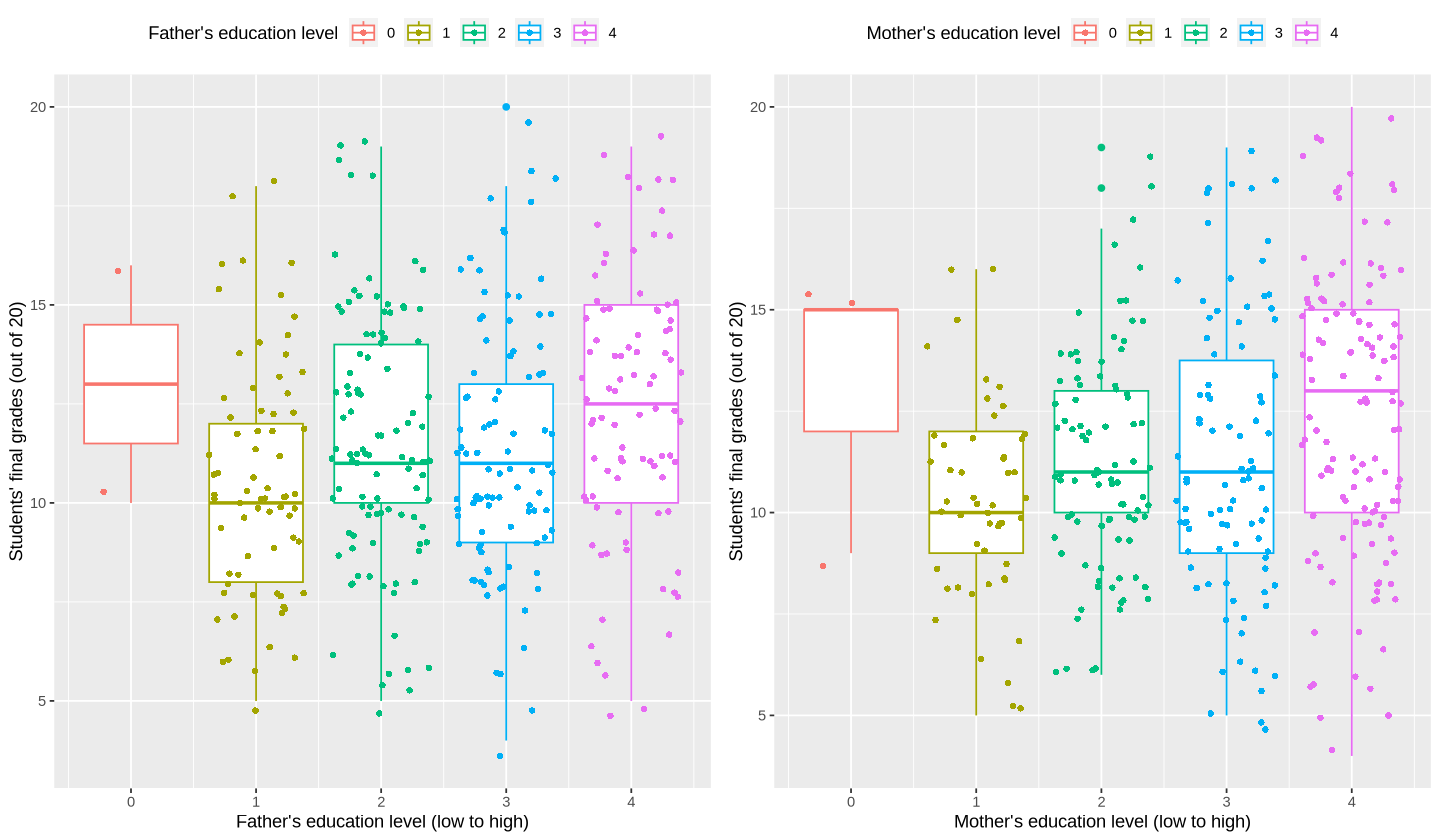

In [57]:
options(repr.plot.width = 12)
plots_medu_fedu <- list()

plots_medu_fedu[[1]] <- students_filtered |>
                            ggplot(aes(x = Fedu, y = G3, group = Fedu, color = as.factor(Fedu))) +
                            geom_boxplot() +
                            geom_jitter(shape = 16) +
                            theme(legend.position = "top") +
                            xlab("Father's education level (low to high)") +
                            ylab("Students' final grades (out of 20)") +
                            labs(color = "Father's education level")

plots_medu_fedu[[2]] <- students_filtered |>
                            ggplot(aes(x = Medu, y = G3, group = Medu, color = as.factor(Medu))) +
                            geom_boxplot() +
                            geom_jitter(shape = 16) +
                            theme(legend.position = "top") +
                            xlab("Mother's education level (low to high)") +
                            ylab("Students' final grades (out of 20)") +
                            labs(color = "Mother's education level")

grid.arrange(grobs = plots_medu_fedu, ncol = 2)

#### Figure 2

**IMPORTANT**: in order to compare student performance across low and high parental education levels, we will aggregate the parental education variables (`Medu` and `Fedu`) into binary variables. `Medu` will become `hi_medu` which takes the value of `TRUE` when a mother has received secondary education or higher (3-4), and `FALSE` for mothers with no education up to 9th grade (0-2). The same aggregation is performed for fathers education (`Fedu`).

In [58]:
students_filtered <- students_filtered |> mutate(Medu = ifelse(Medu > 2, TRUE, FALSE), 
                               Fedu = ifelse(Fedu > 2, TRUE, FALSE)) |>
            select(G3, hi_medu = Medu, hi_fedu = Fedu)

In [59]:
# show counts + mean grades in each aggregated category
students_filtered |> group_by(hi_fedu) |> summarize(count = n(), mean_g3 = mean(G3)) 

students_filtered |> group_by(hi_medu) |> summarize(count = n(), mean_g3 = mean(G3)) 

hi_fedu count mean_g3 
1 FALSE   175   11.18286
2  TRUE   182   11.85165

hi_medu count mean_g3 
1 FALSE   142   10.93662
2  TRUE   215   11.91163

There are an adequate number of observations in each of the 4 groups we will be studying for the purposes of our tests (no severe class imbalances, and enough to apply the CLT in our hypothesis tests). The sample mean grade of students with more educated mothers is higher than those with less educated mothers. The same is true for the sample mean grade of students with more educated fathers as well. These results are visualized with boxplots below:

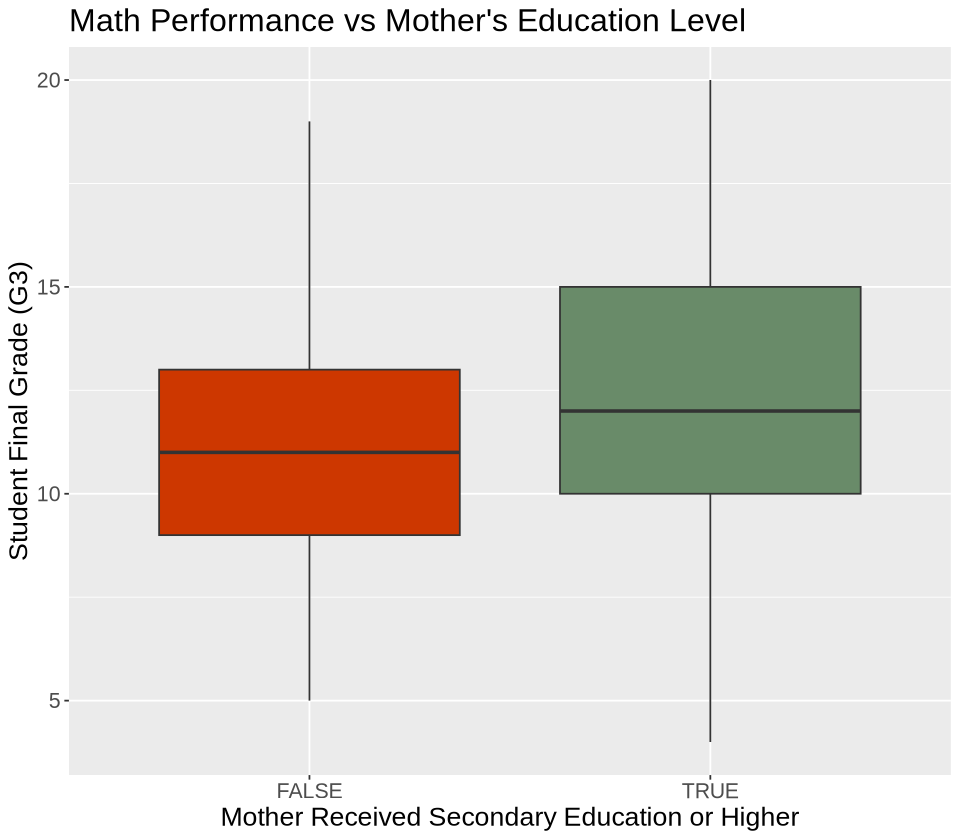

In [60]:
options(repr.plot.width = 8)

ggplot(students_filtered, aes(hi_medu, G3)) +
    geom_boxplot(fill = c("orangered3", "darkseagreen4")) +
    labs(x = "Mother Received Secondary Education or Higher", y = "Student Final Grade (G3)") +
    ggtitle("Math Performance vs Mother's Education Level") +
    theme(text = element_text(size = 16))

#### Figure 3

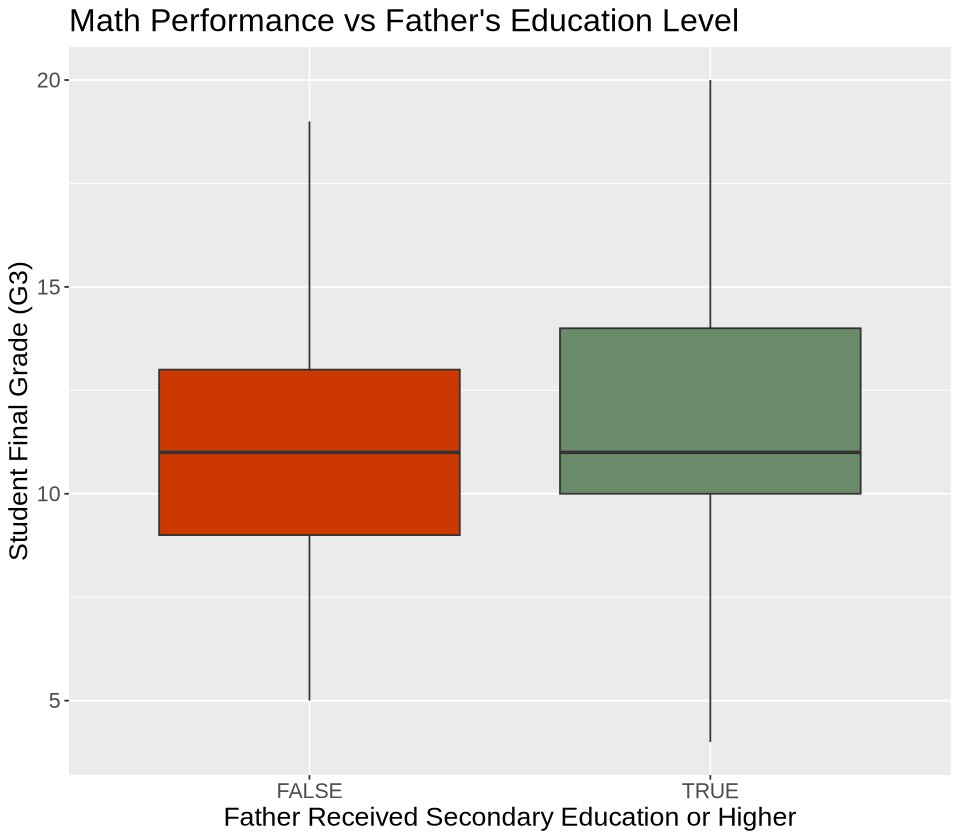

In [61]:
ggplot(students_filtered, aes(hi_fedu, G3)) +
    geom_boxplot(fill = c("orangered3", "darkseagreen4")) +
    labs(x = "Father Received Secondary Education or Higher", y = "Student Final Grade (G3)") +
    ggtitle("Math Performance vs Father's Education Level") +
    theme(text = element_text(size = 16))

#### Figure 4

Although the above tables and graphs indicate that the sample mean grades of students with more educated parents are higher, we cannot make any statements about the differences in population parameters given this information alone. We need to obtain the statistical significance of these differences, and use confidence intervals to communicate our inference about the differences in true population parameters of interest:  $\mu_{f-lo}$, $\mu_{f-hi}$, $\mu_{m-lo}$,  and $\mu_{m-hi}$

### Test 1: Mothers' Education Level

In [62]:
mother_summary <- students_filtered |> group_by(hi_medu) |> summarize(count = n(), mean_g3 = mean(G3), sd = sd(G3)) 
mother_summary

# calculate observed test statistic for difference in means
medu_obs_stat <- mother_summary$mean_g3[2] - mother_summary$mean_g3[1]
medu_obs_stat

hi_medu count mean_g3  sd      
1 FALSE   142   10.93662 2.708575
2  TRUE   215   11.91163 3.481138

[1] 0.9750082

Our observed test statistic for the difference $\mu_{m-hi}$ - $\mu_{m-lo}$ (estimated by difference in sample means) is approximately 0.975. We now employ 2 approaches to conduct our hypothesis test, and determine if this value is likely to be observed under the null hypothesis: $\mu_{m-hi}$ = $\mu_{m-lo}$ (equivalently $\mu_{m-hi}$ - $\mu_{m-lo}$ = 0).

#### Approach 1: Permutation Test for Independence + Bootstrap Confidence Interval

First, we use permutation resampling with 5000 repetitions to simulate the null model for the difference in population means. 

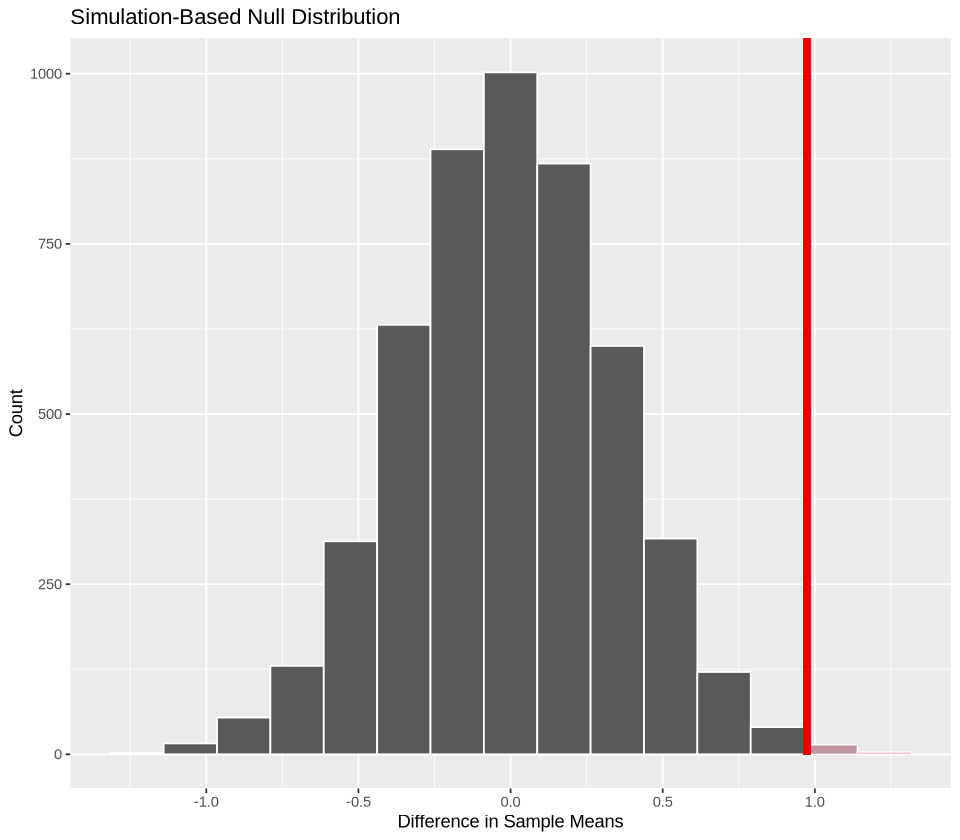

In [63]:
set.seed(5149)

# generate a simulated null distribution via permutation resampling
medu_null_dist <- students_filtered |>
                    specify(formula = G3 ~ hi_medu) |>
                    hypothesize(null = "independence") |>
                    generate(reps = 5000, type = "permute") |>
                    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))

visualize(medu_null_dist) +
    shade_p_value(obs_stat = medu_obs_stat, direction = "greater") +
    labs(x = "Difference in Sample Means", y = "Count")

#### Figure 5

In [72]:
# obtain the estimated p-value from our simulated null
medu_null_dist |> get_p_value(obs_stat = medu_obs_stat, direction = "greater")

p_value
1 0.0034

From the above visualization of our null model (for difference in means), it appears highly unlikely that we would observe our test statistic: difference in sample means = 0.975. The reported p-value indicates that our test statistic is **highly** unlikely to be observed under $H_0$.

At the 5% significance level, we reject $H_0$ and conclude that the mean grade of students with highly educated mothers is greater than those with less educated mothers ($\mu_{m-hi}$ > $\mu_{m-lo}$).

Next, we generate a bootstrap sampling distribution of differences in sample means to obtain a 95% confidence interval for our test.

lower_ci  upper_ci
1 0.4379142 1.500067

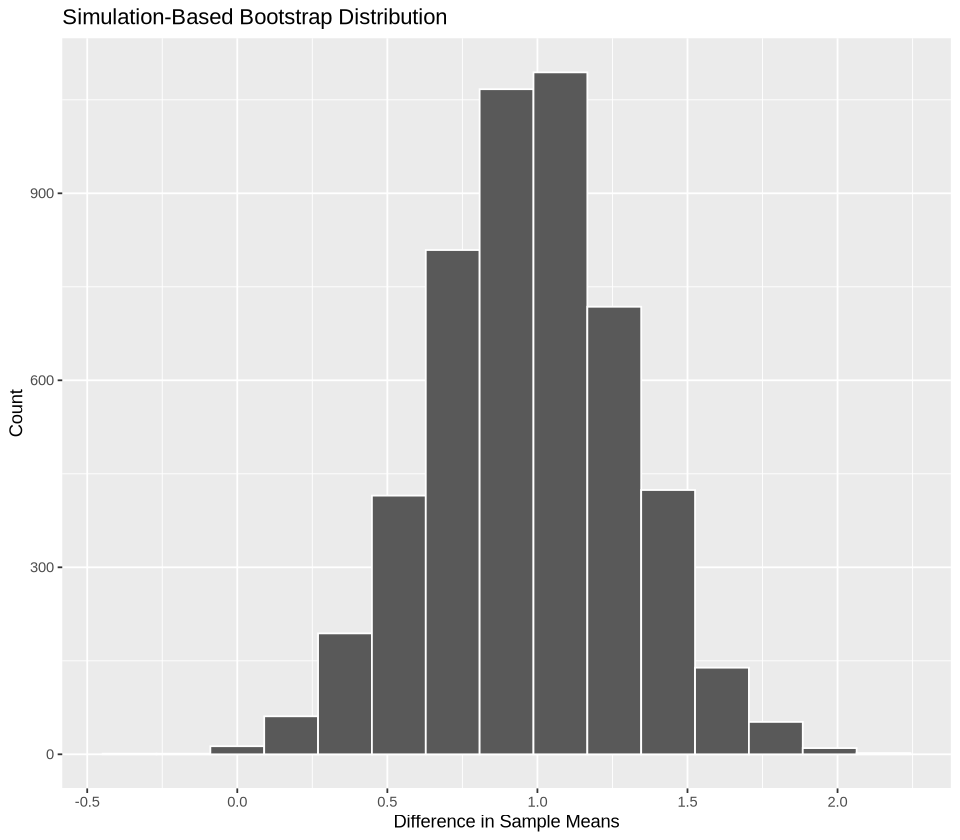

In [65]:
set.seed(5149)

# Visualize bootstrap sampling distribution with 5000 reps
medu_boot_dist <- students_filtered |>
                    specify(formula = G3 ~ hi_medu) |>
                    generate(reps = 5000, type = "bootstrap") |>
                    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))

visualize(medu_boot_dist) + labs(x = "Difference in Sample Means", y = "Count")
# using 90% CI because get_ci returns for 2 sided test always
# want 5% on left side for 95% one sided CI
get_ci(medu_boot_dist, level = 0.9)

#### Figure 6

We obtain a one sided confidence interval from the above bootstrap distribution of [0.438, $\infty$]. That is: in the process of sampling and conducting this test many times, we would expect 95% of our differences in sample mean grades to be greater than 0.438. This result further supports the conclusion of our hypothesis test: the lower bound here is almost a 2.5% difference in final grade (0.5 / 20) between students with less educated mothers and those with highly educated mothers.

#### Approach 2: CLT Hypothesis Test + Confidence Interval

We now conduct a two sample t-test to perform the same hypothesis test.

In [76]:
t_test_result <- t.test(filter(students_filtered, hi_medu == TRUE)$G3, 
                        filter(students_filtered, hi_medu == FALSE)$G3, alternative = "greater")
tidy(t_test_result)

estimate  estimate1 estimate2 statistic p.value     parameter conf.low 
1 0.9750082 11.91163  10.93662  2.966458  0.001611131 345.5167  0.4329283
  conf.high method                  alternative
1 Inf       Welch Two Sample t-test greater

The very low p-value again indicates that our test statistic is highly unlikely to be observed under $H_0$.  At the 5% significance level, we reject the null hypothesis. The confidence interval obtained via the two sample t-test is very similar to the one previously obtained via bootstrapping.

**Summary of test 1**: both resampling and asymptotic approaches yielded very similar results. Both rejected $H_0$ at the 5% significance level and obtained closely aligned confidence intervals for the true difference in population means ($\mu_{m-hi}$ - $\mu_{m-lo}$). We believe this is due to the large sample size and nicely distributed (almost normal) student data. We consider both approaches to be trustworthy, as they yield near identical results and there is ample data for both to work effectively. We conclude that there is statistically significant evidence to support a difference in student mathematical performance between students with more/less educated mothers. Students with more educated mothers are highly likely to perform better in math than students with less educated mothers.

### Test 2: Fathers' Education Level

In [68]:
father_summary <- students_filtered |> group_by(hi_fedu) |> summarize(count = n(), mean_g3 = mean(G3), sd = sd(G3)) 
father_summary

# calculate observed test statistic for difference in means
fedu_obs_stat <- father_summary$mean_g3[2] - father_summary$mean_g3[1]
fedu_obs_stat

hi_fedu count mean_g3  sd      
1 FALSE   175   11.18286 3.124016
2  TRUE   182   11.85165 3.299920

[1] 0.6687912

Our observed test statistic for the difference $\mu_{f-hi}$ - $\mu_{f-lo}$ (estimated by difference in sample means) is approximately 0.669. We now employ 2 approaches to conduct our hypothesis test, and determine if this value is likely to be observed under the null hypothesis: $\mu_{f-hi}$ = $\mu_{f-lo}$ (equivalently $\mu_{f-hi}$ - $\mu_{f-lo}$ = 0).

#### Approach 1: Permutation Test for Independence + Bootstrap Confidence Interval

First, we use permutation resampling with 5000 repetitions to simulate the null model for the difference in population means. 

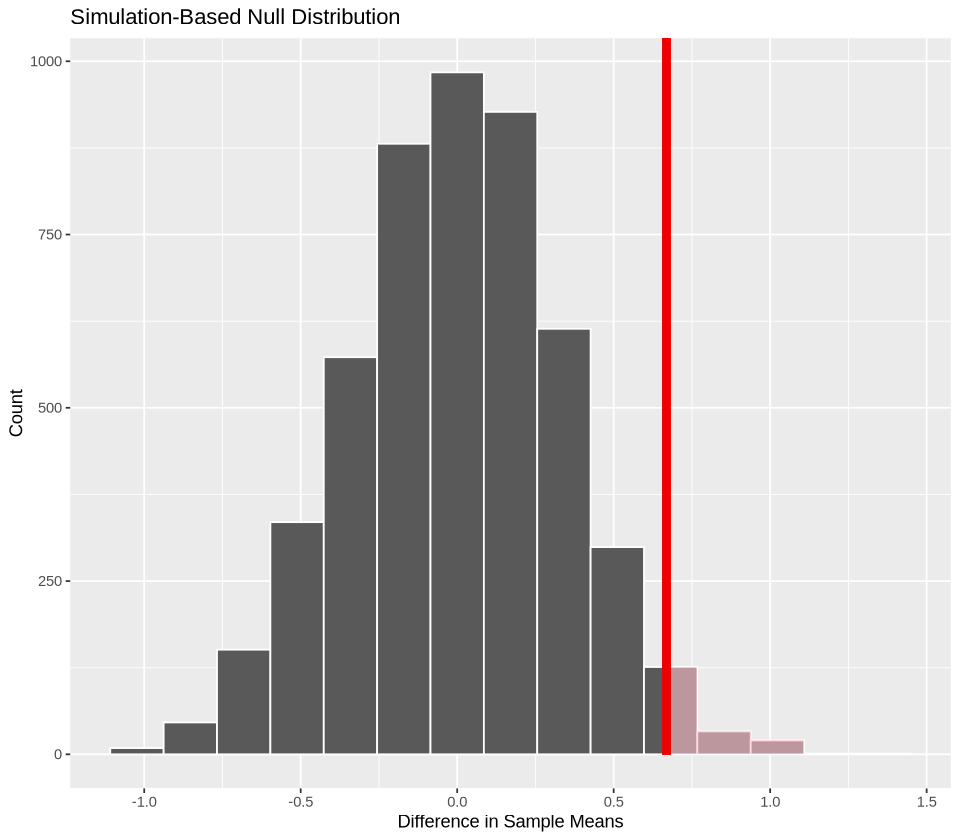

In [69]:
set.seed(5149)

# generate a simulated null distribution via permutation resampling
fedu_null_dist <- students_filtered |>
                    specify(formula = G3 ~ hi_fedu) |>
                    hypothesize(null = "independence") |>
                    generate(reps = 5000, type = "permute") |>
                    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))

visualize(fedu_null_dist) +
    shade_p_value(obs_stat = fedu_obs_stat, direction = "greater") +
    labs(x = "Difference in Sample Means", y = "Count")

#### Figure 7

In [71]:
# obtain the estimated p-value from our simulated null
fedu_null_dist |> get_p_value(obs_stat = fedu_obs_stat, direction = "greater")

p_value
1 0.0218

From the above visualization of our null model (for difference in means), it appears unlikely that we would observe our test statistic: difference in sample means = 0.669. The reported p-value indicates that our test statistic is unlikely to be observed under $H_0$.

At the 5% significance level, we reject $H_0$ and conclude that the mean grade of students with more educated fathers is greater than those with less educated fathers ($\mu_{f-hi}$ > $\mu_{f-lo}$).

Next, we generate a bootstrap sampling distribution of differences in sample means to obtain a 95% confidence interval for our test.

lower_ci   upper_ci
1 0.09819562 1.222196

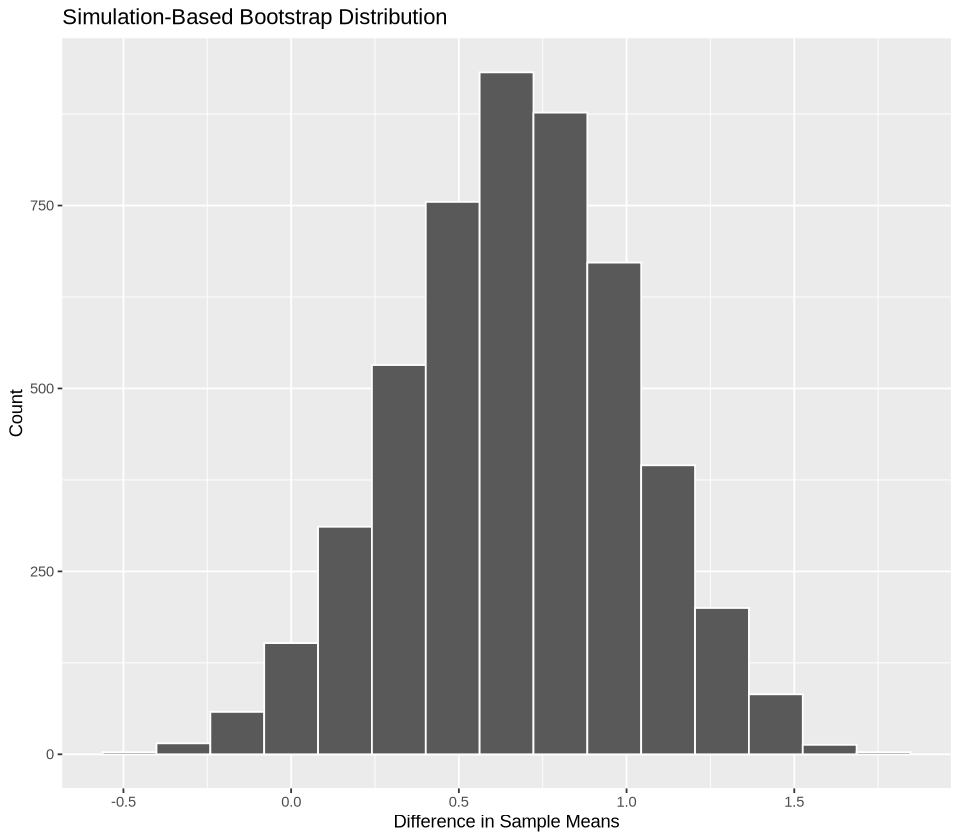

In [73]:
set.seed(5149)

# Visualize bootstrap sampling distribution with 5000 reps
fedu_boot_dist <- students_filtered |>
                    specify(formula = G3 ~ hi_fedu) |>
                    generate(reps = 5000, type = "bootstrap") |>
                    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))

visualize(fedu_boot_dist) + labs(x = "Difference in Sample Means", y = "Count")
# using 90% CI because get_ci returns for 2 sided test always
# want 5% on left side for 95% one sided CI
get_ci(fedu_boot_dist, level = 0.9)

#### Figure 8

We obtain a one sided confidence interval from the above bootstrap distribution of [0.098, $\infty$]. That is: in the process of sampling and conducting this test many times, we would expect 95% of our differences in sample mean grades to be greater than 0.098. This interval suggests a less extreme difference than our previous test with mothers' education.

#### Approach 2: CLT Hypothesis Test + Confidence Interval

We now conduct a two sample t-test to perform the same hypothesis test.

In [75]:
t_test_result <- t.test(filter(students_filtered, hi_fedu == TRUE)$G3, 
                        filter(students_filtered, hi_fedu == FALSE)$G3, alternative = "greater")
tidy(t_test_result)

estimate  estimate1 estimate2 statistic p.value    parameter conf.low 
1 0.6687912 11.85165  11.18286  1.967027  0.02497935 354.9154  0.1080757
  conf.high method                  alternative
1 Inf       Welch Two Sample t-test greater

The low p-value again indicates that our test statistic is unlikely to be observed under $H_0$.  At the 5% significance level, we reject the null hypothesis. The confidence interval obtained via the two sample t-test is very similar to the one previously obtained via bootstrapping.

**Summary of test 2**: both resampling and asymptotic approaches yielded similar results for the fathers' education hypothesis test. Both rejected $H_0$ at the 5% significance level and obtained closely aligned confidence intervals for the true difference in population means ($\mu_{f-hi}$ - $\mu_{f-lo}$). Again, we consider both approaches to be trustworthy, due to the agreeing results and large sample size. We conclude that there is statistically significant evidence to support a difference in student mathematical performance between students with more/less educated fathers. Students with more educated fathers are highly likely to perform better in math than students with less educated fathers.

## Discussion

Our project explored the influence of parental education levels on the mathematical achievements of secondary school students. Utilizing data collected by Paulo Cortez and Alice Silva from Portuguese secondary schools, our analysis revealed a statistically significant relationship between students' academic performance in mathematics and their parents' educational backgrounds. We found that students whose parents have higher levels of education are likely to achieve better math grades. This finding supports the hypothesis that parental education significantly affects children's academic outcomes, resonating with the findings of Dubow et al. (2009) and Marks (2006), who noted the strong predictive value of parental education for long-term success.

The implications of our study extend beyond academic performance, highlighting the need for policy interventions to support students from less educated backgrounds and reduce educational inequities. Additionally, our research underscores the importance of considering family socio-economic contexts in educational planning and resource allocation.

Future research could expand on our findings by exploring the broader impacts of parental education levels on children's overall development, both academically and socially, and by examining data from different regions to determine the universality of our findings.

In conclusion, our project reinforces the link between parental education and student academic performance, particularly in mathematics, and calls for policies that promote equity and inclusivity in education.

## References

Blake, J. (1989). Family size and achievement (studies in demography). University of California Press.

Cortez, Paulo & Silva, Alice. (2008). Using data mining to predict secondary school student performance. EUROSIS. 

Dubow, E. F., Boxer, P., &amp; Huesmann, L. R. (2009). Long-term effects of parents’ education on Children’s educational and occupational success: Mediation by family interactions, child aggression, and teenage aspirations. Merrill-Palmer Quarterly, 55(3), 224–249. https://doi.org/10.1353/mpq.0.0030

Marks, G. N. (2006). Family size, family type and student achievement: Cross-national differences and the role of socioeconomic and school factors. Journal of Comparative Family Studies, 37(1), 1–24. https://doi.org/10.3138/jcfs.37.1.1

Riala, K., Isohanni, I., Jokelainen, J., Jones, P. B., &amp; Isohanni, M. (2003). The Relationship between Childhood Family Background and Educational Performance, with Special Reference to Single-parent Families: A Longitudinal Study. Social Psychology of Education, 6(4), 349–365. https://doi.org/10.1023/a:1025608401292 